In [1]:
import numpy as np
import matplotlib.pyplot as plt
import burst_detector as bd
import seaborn as sns
from scipy.stats import wasserstein_distance, poisson, pearsonr
import pandas as pd
import math
import os

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
n_chan = 385
times = np.load('../data/neuropixels_dohoung/KS2.5/phy_in/spike_times.npy').flatten()
clusters = np.load('../data/neuropixels_dohoung/KS2.5/phy_in/spike_clusters.npy').flatten()
mean_wf = np.load("../data/neuropixels_dohoung/KS2.5/phy_in/mean_waveforms.npy")

counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv("../data/neuropixels_dohoung/KS2.5/phy_in/cluster_group.tsv", sep="\t")

In [3]:
# load raw data
rawData = np.memmap("../data/neuropixels_dohoung/KS2.5/catgt_ANM480363_20210527_pfc320_hpc180_g0/ANM480363_20210527_pfc320_hpc180_g0_imec1/ANM480363_20210527_pfc320_hpc180_g0_tcat.imec1.ap.bin", dtype='int16', mode='r')
data = np.reshape(rawData, (int(rawData.size/n_chan), n_chan))

In [4]:
params = {}

# input files
params['KS_folder'] = "../data/neuropixels_dohoung/KS2.5/phy_in"

# mean calculation
params['calc_means'] = False
params['fs'] = 30000
params['n_chan'] = 385
params['pre_samples'] = 20
params['post_samples'] = 62
params['max_spikes'] = 2000

# mean sim
params['jitter'] = False
params['jitter_amt'] = -1
params['sim_thresh'] = .6
params['sp_num_thresh'] = 100

# xcorr metric
params['n_iter'] = 50
params['shuffle_bin_width'] = 0.1
params['window_size'] = 0.025
params['xcorr_bin_width'] = .001
params['overlap_tol'] = 10/params['fs']
params['max_window'] = 0.25
params['min_xcorr_rate'] = .5/.001

# ref p
params['ref_pers'] = [0.002, 0.005, 0.010]
params['max_viol'] = 0.01

params['max_dist'] = 10
params['final_thresh'] = .75

### Time splits

In [5]:
times_multi = bd.find_times_multi(times/30000, clusters, np.arange(clusters.max()))

In [6]:
def calc_time_split(c1, c2, times_multi):
    c1, c2 = bd.bin_spike_trains(times_multi[c1], times_multi[c2], 20)
    c1a = np.zeros(124)
    c2a = np.zeros(124)
    c1a[:c1.shape[0]] = c1
    c2a[:c2.shape[0]] = c2

    c1b = c1a - c1a.mean()
    c2b = c2a- c2a.mean()
    mask = (c1a > .15*c1a.max()) | ((c2a > .15*c2a.max())) 
    c1b = c1b[mask]
    c2b = c2b[mask]

    r = pearsonr(c1b, c2b)
    return r.statistic

In [8]:
n_clust = clusters.max()+1

In [12]:
time_splits = np.zeros((n_clust, n_clust))

for i in range(n_clust):
    for j in range(n_clust):
        if pass_ms[i, j]:
            time_splits[i,j] = calc_time_split(i,j,times_multi)

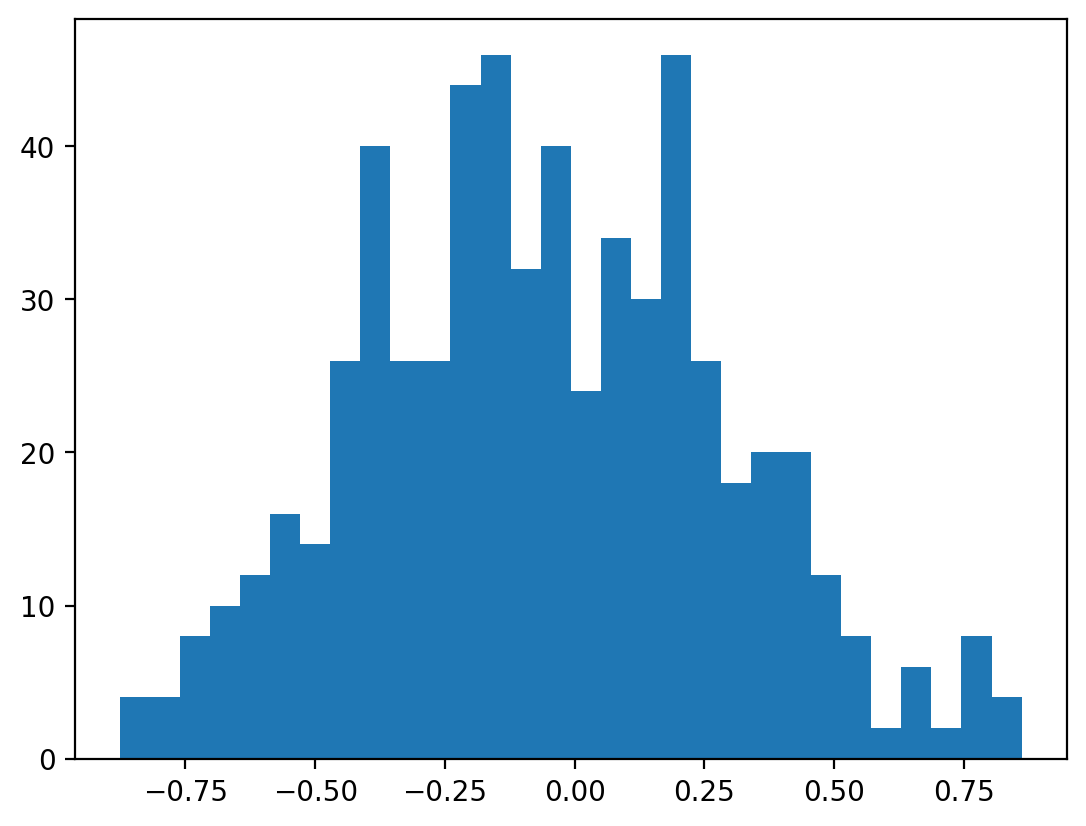

In [13]:
plt.hist(time_splits[pass_ms], bins=30);

In [614]:
ro_list = np.array(np.unravel_index(np.argsort(time_splits.flatten()), shape=time_splits.shape)).T[::][::2]

In [615]:
ro_list[:30]

array([[158,  36],
       [129,  36],
       [131, 129],
       [ 52,  49],
       [  6,   3],
       [129, 158],
       [ 37,  36],
       [120,  11],
       [136,  49],
       [130, 129],
       [129,  35],
       [129,  39],
       [156,  92],
       [ 37, 130],
       [ 20, 122],
       [106, 154],
       [128, 129],
       [ 36,  35],
       [132,  39],
       [ 98,  92],
       [ 36, 127],
       [106, 107],
       [ 36,  39],
       [ 92, 150],
       [ 37, 131],
       [150,  93],
       [113, 107],
       [  9,   8],
       [121,  20],
       [136,  46]], dtype=int64)

In [619]:
spatial_splits[92,98]

0.5576923076923077

### Spatial splits

In [259]:
def get_closest_channels(channel_positions, channel_index, n=None):
    """Get the channels closest to a given channel on the probe."""
    x = channel_positions[:, 0]
    y = channel_positions[:, 1]
    x0, y0 = channel_positions[channel_index]
    d = (x - x0) ** 2 + (y - y0) ** 2
    out = np.argsort(d)
    if n:
        out = out[:n]
    return out

In [380]:
def get_dists(channel_positions, ref_chan, target_chan):
    x = channel_positions[:, 0]
    y = channel_positions[:, 1]
    x0, y0 = channel_positions[ref_chan]
    d = (x - x0) ** 2 + (y - y0) ** 2
    # d[y < y0] *= -1
    return d[target_chan]

In [261]:
channel_pos = np.load('../data/neuropixels_dohoung/KS2.5/phy_in/channel_positions.npy')
channel_map = np.load('../data/neuropixels_dohoung/KS2.5/phy_in/channel_map.npy').flatten()

In [272]:
channel_shanks = (x/250).astype("int")

In [312]:
def find_best_channels(template):
    amplitude_threshold = 0
    
    amplitude = template.max(axis=0) - template.min(axis=0)
    best_channel = np.argmax(amplitude)
    max_amp = amplitude[best_channel]
    
    peak_channels = np.nonzero(amplitude >= amplitude_threshold * max_amp)[0]
    
    close_channels = get_closest_channels(channel_pos, best_channel, 12)

    shank = channel_shanks[best_channel]
    channels_on_shank = np.nonzero(channel_shanks == shank)[0]
    close_channels = np.intersect1d(close_channels, channels_on_shank)
    channel_ids = np.intersect1d(close_channels, peak_channels)
    
    return channel_ids, best_channel
    

In [606]:
def calc_template_mismatch(clust_id, templates, channel_map, channel_pos, mean_wf):
    ch_ids, peak_channel = find_best_channels(templates[clust_id])
    
    # calculate and rank distances (proximity)
    dists = get_dists(channel_pos, peak_channel, ch_ids)
    prox_order = np.argsort(dists)[::-1]
    prox_ranks = np.argsort(dist_order)
    
    # calculate and rank amplitudes
    means = mean_wf[clust_id, ch_ids, :]
    amp = means.max(axis=1) - means.min(axis=1)
    amp_order = np.argsort(amp)
    amp_ranks = np.argsort(amp_order)
    
    # calculate magnitude and direction of mismatch
    mismatch = np.abs((prox_ranks[prox_order] - amp_ranks[prox_order])[int(ch_ids.shape[0]/2):].sum()/26) # 26 is maximum possible raw mismatch
    direc = -2
    shift = channel_pos[ch_ids[amp.argmax()],1] - channel_pos[ch_ids[dists.argmin()], 1]
    
    if shift > 0:
        direc = 1
    elif shift == 0:
        direc = 0
    elif shift < 0:
        direc = -1
        
    return mismatch, direc, peak_channel

In [607]:
calc_template_mismatch(51, templates, channel_map, channel_pos, mean_wf)

(0.9615384615384616, -1, 172)

In [608]:
# calculate template mismatch per cluster
mismatch = np.zeros(n_clust)
direc = np.zeros(n_clust)
peak_channel = np.zeros(n_clust)

for i in range(n_clust):
    if (labels.loc[labels['cluster_id']==i, 'group'].item() == 'good') and (i in counts):
        mismatch[i], direc[i], peak_channel[i]  = calc_template_mismatch(i, templates, channel_map, channel_pos, mean_wf)

In [609]:
spatial_splits = np.zeros_like(mean_sim)

# assess cluster pairs
for i in range(n_clust):
    for j in range(n_clust):
            if np.abs(peak_channel[i] - peak_channel[j]) <= 12:
                spatial_splits[i,j] = (mismatch[i] + mismatch[j])/2
                if direc[i] == direc[j]:
                    spatial_splits[i,j] -= .2
            

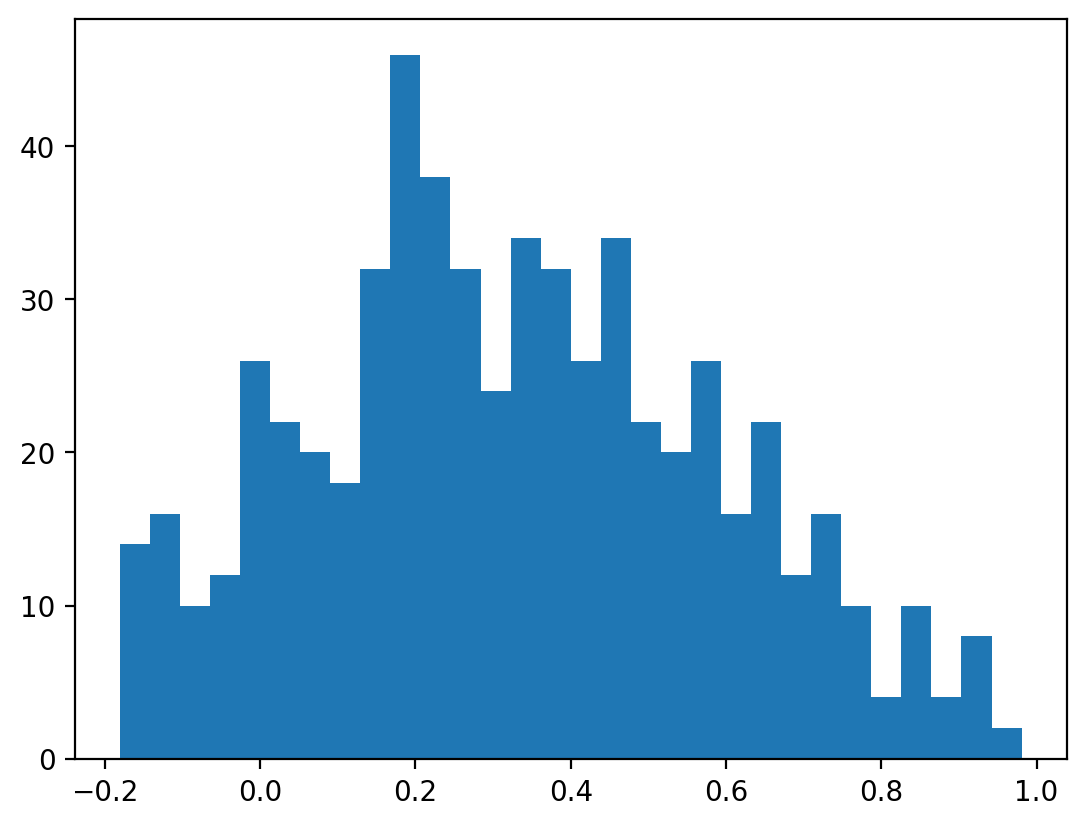

In [611]:
plt.hist(spatial_splits[pass_ms].flatten(), bins=30);

In [597]:
(spatial_splits > 0.6).sum()

63

In [600]:
time_splits[9, 118]

-0.25339861270278263

In [591]:
ro_list = np.array(np.unravel_index(np.argsort(spatial_splits.flatten()), shape=spatial_splits.shape)).T[::-1][::2]

In [598]:
ro_list[:63]

array([[136,  51],
       [ 51, 135],
       [135,  51],
       [ 51,  55],
       [ 55,  51],
       [ 54,  51],
       [ 51,  54],
       [157,  98],
       [148,  98],
       [119,  13],
       [ 51,  49],
       [142,  66],
       [ 66, 142],
       [119,  12],
       [ 35, 127],
       [120, 119],
       [ 51, 137],
       [135,  54],
       [ 55,  54],
       [ 75,  82],
       [ 54,  53],
       [ 49,  54],
       [115,  98],
       [127, 129],
       [129, 127],
       [ 50,  51],
       [142, 142],
       [ 52,  54],
       [ 54,  52],
       [127, 158],
       [118, 119],
       [  8, 119],
       [ 11,  13],
       [ 54, 137],
       [  9, 119],
       [136, 136],
       [127,  31],
       [ 82,  66],
       [ 35,  36],
       [ 11,  12],
       [119,  11],
       [ 75,  66],
       [ 66,  75],
       [142,  69],
       [ 13,   7],
       [ 11, 120],
       [ 82,  83],
       [ 50,  54],
       [ 54,  50],
       [ 66, 161],
       [ 98,  91],
       [117, 157],
       [  7,

### Mean similarity

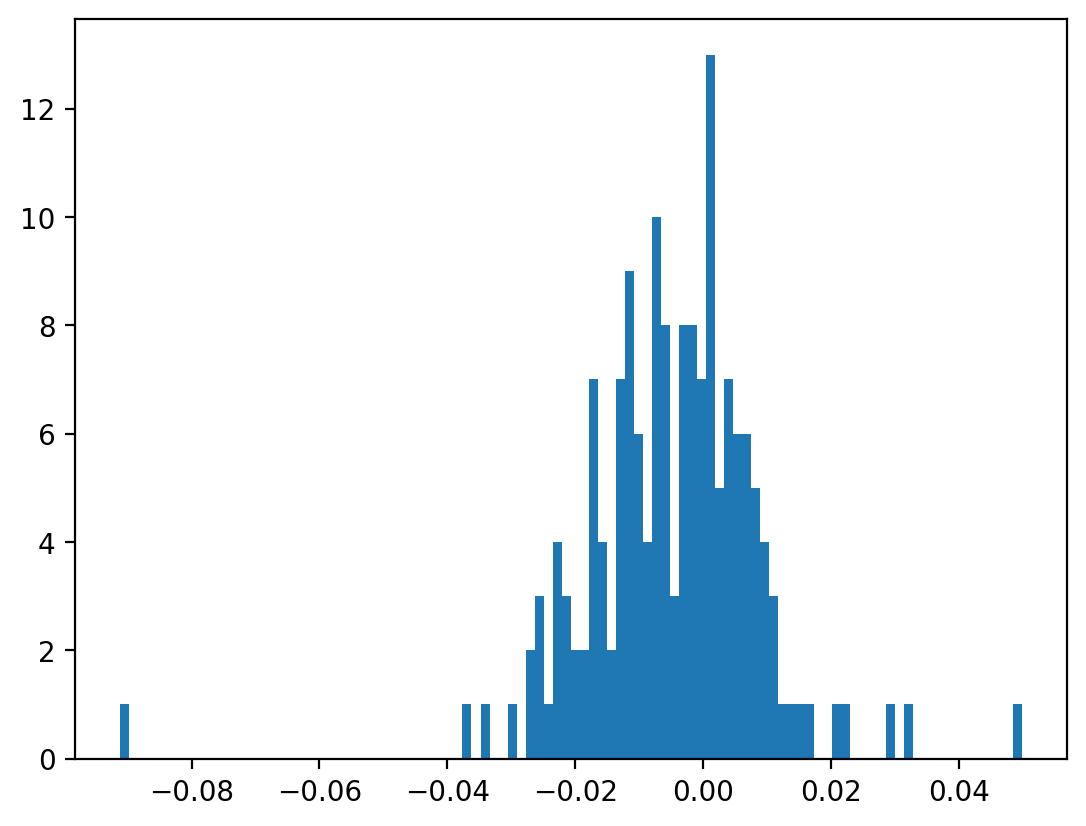

In [188]:
plt.hist(mean_sim[final_metric > .75] - cross_sim[final_metric > .75], bins=100);

In [10]:
mean_sim, offset, wf_means_norm, mean_wf, pass_ms = bd.stages.calc_mean_sim(data, times, clusters, counts, clusters.max()+1, labels, mean_wf, params)

In [177]:
mean_sim.flatten().shape

(27225,)

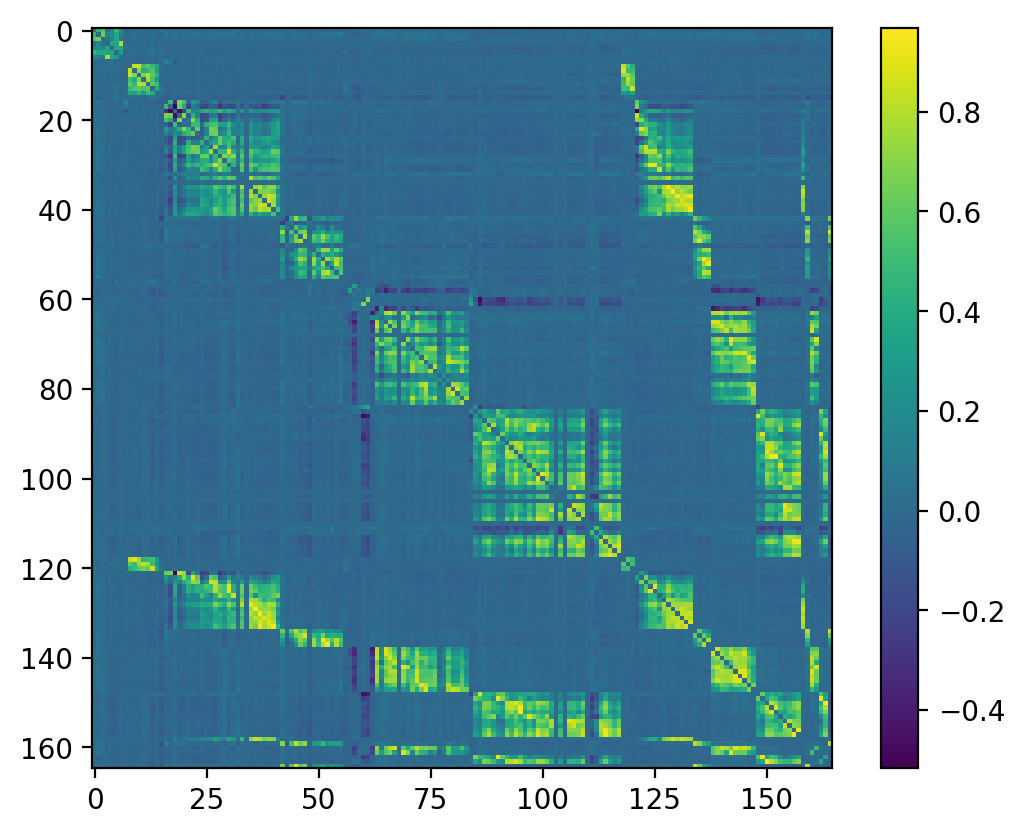

In [6]:
plt.imshow(mean_sim); plt.colorbar();

### Cross projection similarity

In [7]:
spikes = {}
for c1 in range(counts.shape[0]):
    for c2 in range(c1+1, counts.shape[0]):
        if pass_ms[c1,c2]:
            if c1 not in spikes:
                spikes[c1] = bd.extract_spikes(data, times, clusters, c1, n_chan=params['n_chan'], max_spikes=params['max_spikes'])
            if c2 not in spikes:
                spikes[c2] = bd.extract_spikes(data, times, clusters, c2, n_chan=params['n_chan'], max_spikes=params['max_spikes'])
# ~ 2.5 mins

In [8]:
data = None

In [9]:
cross_sim = bd.stages.calc_cross_sim(spikes, wf_means_norm, offset, pass_ms, counts)
#~ 4 mins

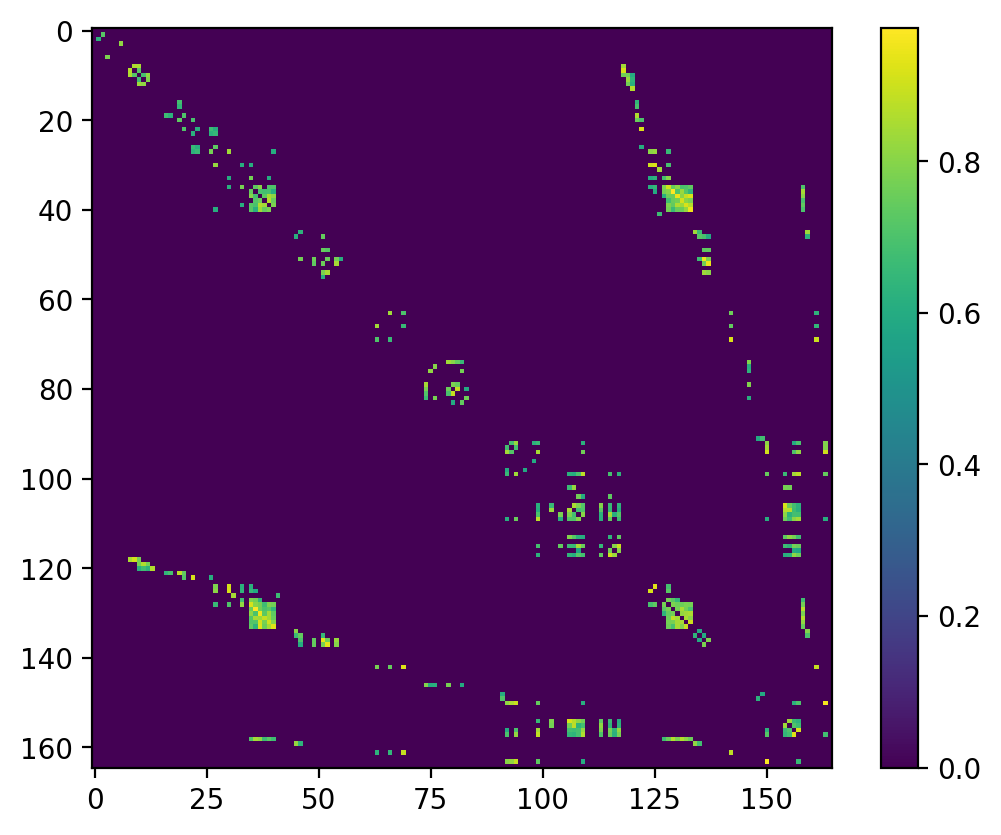

In [10]:
plt.imshow(cross_sim); plt.colorbar();

### Cross-correlation metric

In [11]:
xcorr_sig, xgrams, shfl_xgrams = bd.stages.calc_xcorr_metric(times, clusters, counts, pass_ms, params)

#~ 2 mins

In [224]:
import multiprocess as mp
from multiprocess.pool import ThreadPool as Pool
import itertools
import functools

In [232]:
xs, _, _ = calc_xcorr_metric(times, clusters, counts, pass_ms, params)

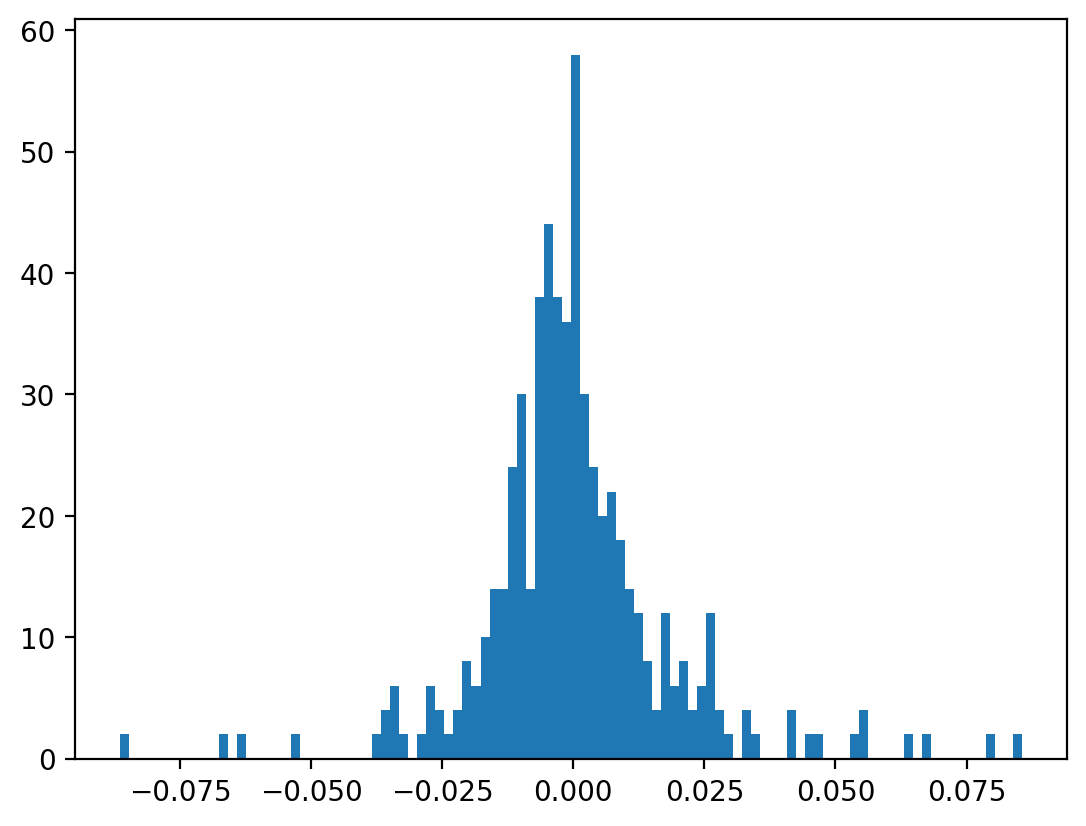

In [242]:
plt.hist(xcorr_sig[pass_ms] - xs[pass_ms], bins = 100);

In [227]:
def calc_xcorr_metric(times, clusters, counts, pass_ms, params):
    # define cross correlogram job
    xcorr_job = functools.partial(
        xcorr_func,
        times=times,
        clusters=clusters,
        params=params
    )
    
    # run cross correlogram jobs
    pool = mp.Pool(mp.cpu_count())
    args = []
    for c1 in range(counts.shape[0]):
        for c2 in range(c1+1, counts.shape[0]):
            if pass_ms[c1,c2]:
                args.append((c1,c2))
    res = pool.starmap(xcorr_job, args)
    
    # convert cross correlogram output to np arrays
    xgrams = np.empty_like(pass_ms, dtype='object')
    x_olaps = np.zeros_like(pass_ms, dtype='int16')
    shfl_xgrams = np.empty_like(pass_ms, dtype='object')
    shfl_olaps = np.zeros_like(pass_ms, dtype='int16')

    for i in range(len(res)):
        c1 = args[i][0]
        c2 = args[i][1]
        xgrams[c1,c2] = res[i][0]
        x_olaps[c1,c2] = res[i][1]
        
    # compute metric
    xcorr_sig = np.zeros_like(pass_ms, dtype='float64')
    
    for c1 in range(counts.shape[0]):
        for c2 in range(c1+1, counts.shape[0]):
            if pass_ms[c1,c2]:
                xcorr_sig[c1,c2] = bd.xcorr_sig(
                    xgrams[c1,c2],
                    np.ones_like(xgrams[c1,c2]),
                    window_size=params['window_size'],
                    xcorr_bin_width=params['xcorr_bin_width'],
                    max_window=params['max_window'],
                    min_xcorr_rate=params['min_xcorr_rate']
                )
    for c1 in range(counts.shape[0]):
        for c2 in range(c1+1, counts.shape[0]):
            xcorr_sig[c2,c1] = xcorr_sig[c1,c2]  
            
    return xcorr_sig, xgrams

In [226]:
def xcorr_func(c1, c2, times, clusters, params):
    import burst_detector as bd
    
    # extract spike times
    clust_times = bd.find_times_multi(times/params['fs'], clusters, [c1, c2])
    c1_times = clust_times[0]
    c2_times = clust_times[1]
    
    # compute xgrams
    return bd.x_correlogram(
        c1_times,
        c2_times,
        window_size=params['max_window'],
        bin_width=params['xcorr_bin_width'],
        overlap_tol=params['overlap_tol']
    )

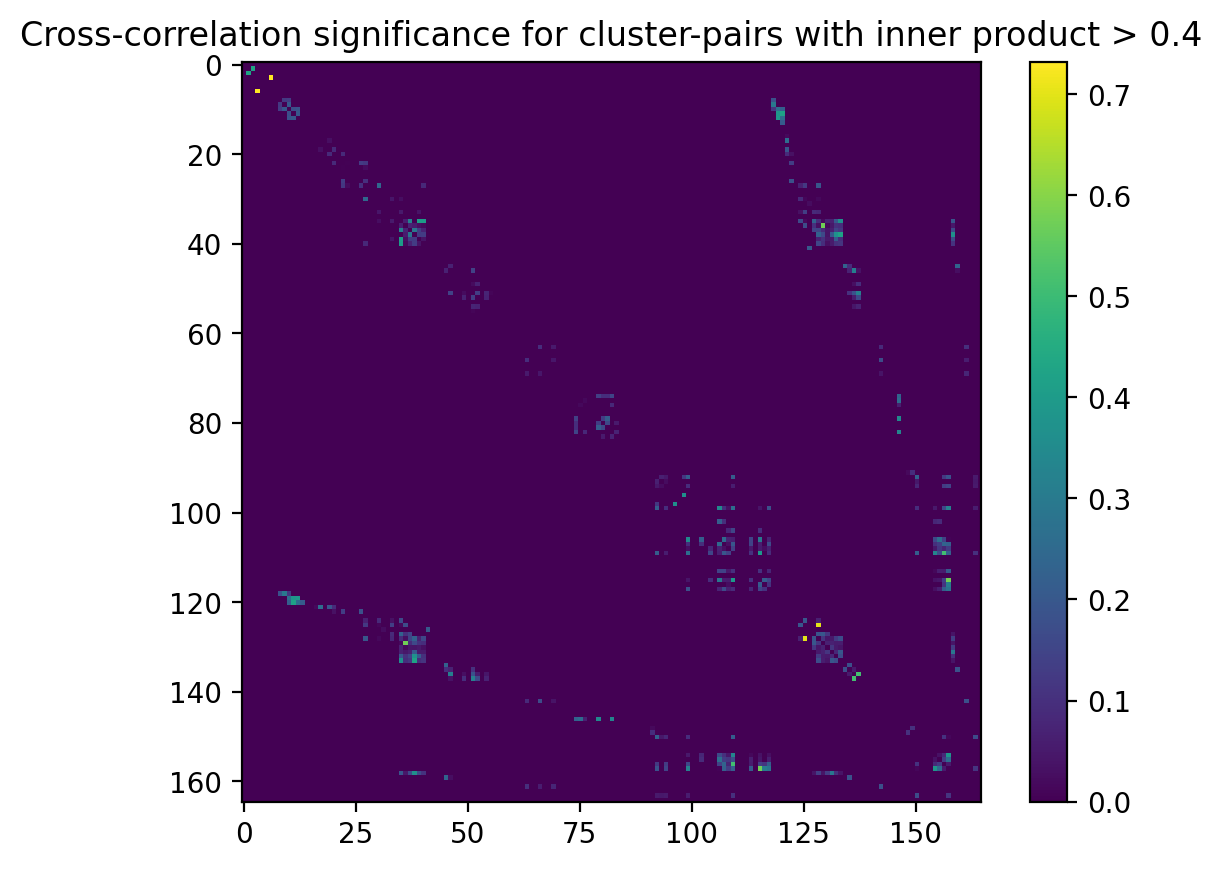

In [12]:
plt.imshow(xcorr_sig); plt.colorbar();
plt.title("Cross-correlation significance for cluster-pairs with inner product > 0.4");

### Refractory period penalty

In [13]:
ref_pen, ref_pers = bd.stages.calc_ref_p(times, clusters, counts, pass_ms, xcorr_sig, params)

# 12s

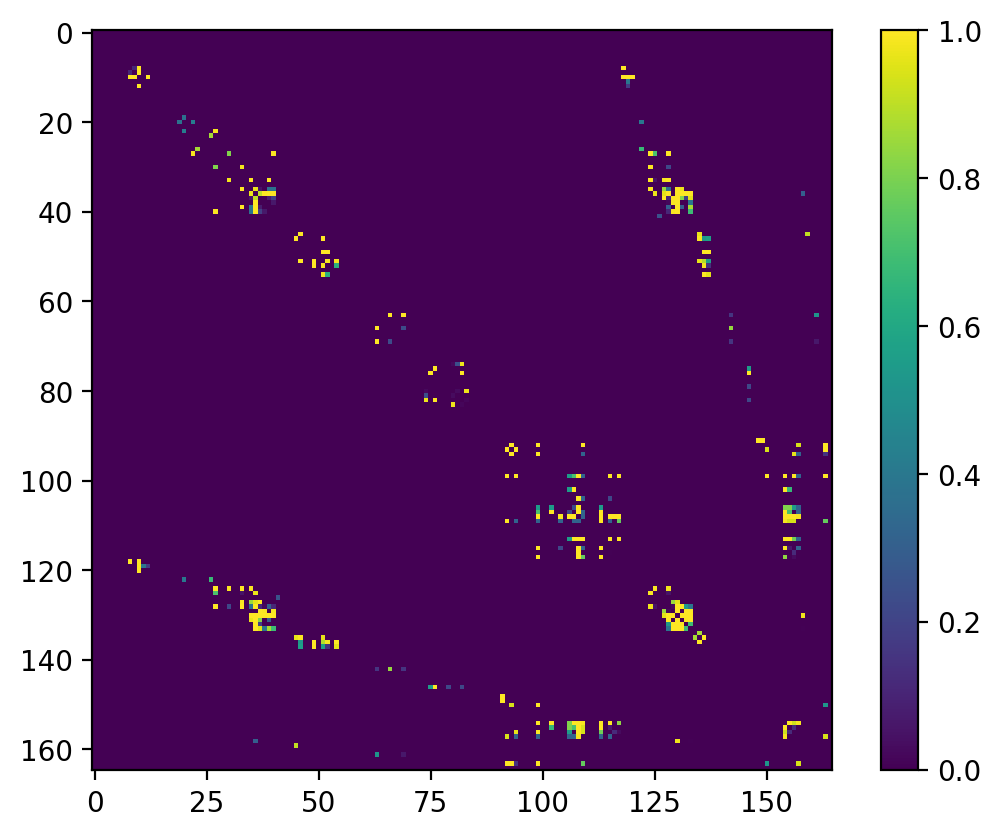

In [14]:
plt.imshow(ref_pen); plt.colorbar();

### Final metric

In [15]:
#final
params['final_thresh'] = 0.75

In [16]:
final_metric = np.zeros_like(mean_sim)

for c1 in range(counts.shape[0]):
    for c2 in range(c1, counts.shape[0]):
        val = np.sqrt(cross_sim[c1,c2]*cross_sim[c2,c1]) + .5*xcorr_sig[c1,c2] - ref_pen[c1,c2]
        final_metric[c1,c2] = max(val,0)
        final_metric[c2,c1] = max(val,0)

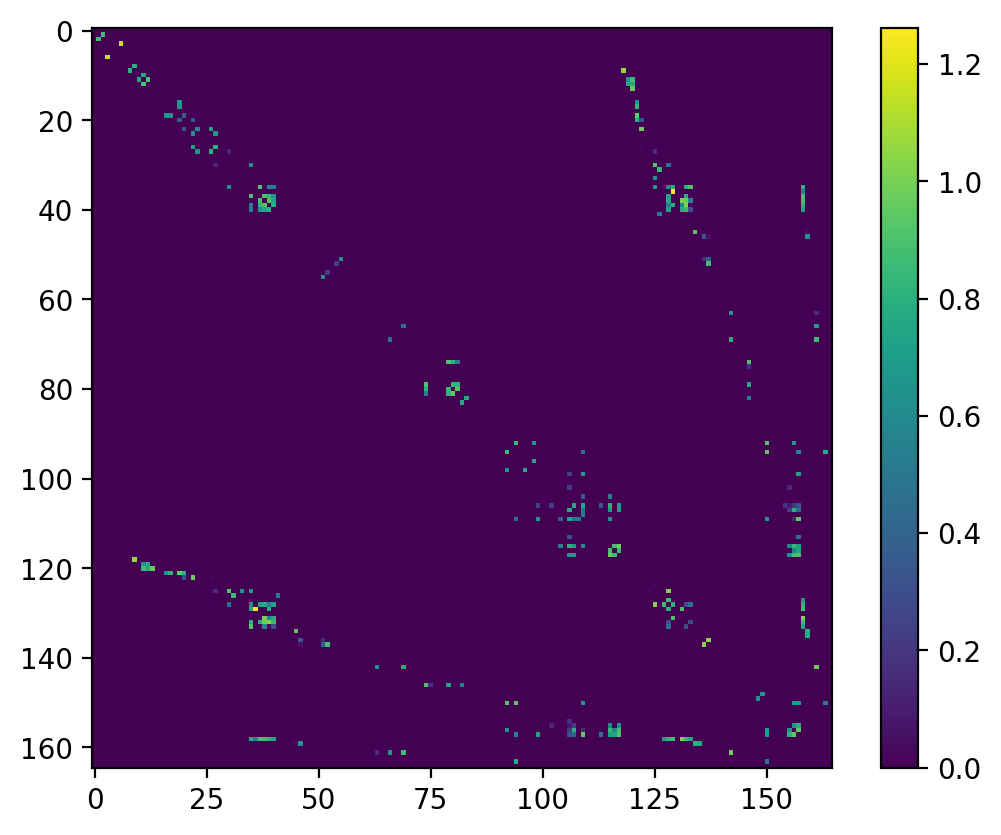

In [17]:
plt.imshow(final_metric); plt.colorbar();

### Merging

In [173]:
from collections import deque
import time

t0 = time.time()

templates = np.load("../data/neuropixels_dohoung/KS2.5/phy_in/templates.npy")
clusters = np.load('../data/neuropixels_dohoung/KS2.5/phy_in/spike_clusters.npy').flatten()
counts = bd.spikes_per_cluster(clusters)

clusters, co, merge_lists, stage_mets = bd.stages.merge_clusters(times, clusters, counts, final_metric, cross_sim, xcorr_sig, ref_pen, mean_wf, params)
counts_sv = counts

t1 = time.time()

time.strftime('%H:%M:%S', time.gmtime(t1-t0))

'00:00:13'

### Write output files

In [168]:
# spike_table
mean_wf = np.load("../data/neuropixels_dohoung/KS2.5/phy_in/mean_waveforms.npy")

# weighted avg new waveforms
new2old = merge_lists[1]

old_n = mean_wf.shape[0]
n = clusters.max() + 1
temp = np.zeros((n, params['n_chan'], params['pre_samples'] + params['post_samples']))
temp[:old_n,:,:] = mean_wf
mean_wf = temp

temp = np.zeros(n)
temp[:old_n] = counts_sv
counts = temp

for i in range(old_n, n):
    c1 = new2old[i][0]; c2 = new2old[i][1]
    mean_wf[i] = (counts[c1]/(counts[c1]+counts[c2])) * mean_wf[c1] + \
    (counts[c2]/(counts[c1]+counts[c2])) * mean_wf[c2]
    counts[i] = counts[c1] + counts[c2]

peak_chans = np.argmax(np.max(mean_wf, 2) - np.min(mean_wf,2),1)
channel_pos = np.load(os.path.join(params['KS_folder'], 'channel_positions.npy'))

# construct spike table dataframe
spike_table = pd.DataFrame(
    {"time": times,
    "cluster": clusters,
    "X": channel_pos[peak_chans[clusters],0],
    "Y": channel_pos[peak_chans[clusters],1]}
    )

os.makedirs(os.path.join(params['KS_folder'], "automerge"), exist_ok=True)
spike_table.to_csv(os.path.join(params['KS_folder'], "automerge", "spike_table.csv"), header=False, index=False)

# write clusters?

In [159]:
times.shape

(894257,)

In [162]:
clusters.max()

194

In [164]:
channel_pos[peak_chans[clusters],0].shape

(894257,)

In [176]:
type(merge_lists[0][129])

numpy.int64

In [210]:
channel_pos = np.load("E:/2022_benchmark/SC038_112319_2_g0_imec2/imec2_ks2/channel_positions.npy")
channel_map = np.load("E:/2022_benchmark/SC038_112319_2_g0_imec2/imec2_ks2/channel_map.npy").flatten()

In [208]:
channel_map.shape

(366, 1)

In [198]:
np.argwhere(channel_pos == 383)

array([[365]], dtype=int64)

In [211]:
chan_dict = {}
for i in range(channel_map.shape[0]):
    chan_dict[channel_map[i]] = i
    

In [219]:
X = np.zeros(times.shape[0]); Y = np.zeros(times.shape[0]); 
for i in range(times.shape[0]):
    X = channel_pos[chan_dict[peak_chans[clusters[i]]],0]
    Y = channel_pos[chan_dict[peak_chans[clusters[i]]],1]

KeyError: 269